In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install asgl

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import math
import asgl
import re
import warnings
warnings.filterwarnings("ignore")

class Explanation:
    def __init__(self, current_sample, history_samples, model_path, original_score, feature_names, group_sizes,target):
        self.current_sample = current_sample
        self.history_samples = history_samples
        self.model_path = model_path
        self.original_score = original_score
        self.feature_names = feature_names
        self.group_size = group_sizes
        self.target = target
        self.relevant_history = [] # List to store relevant history samples
        self.delta = 0.001
        self.step = 10
        self.new_input = []
        self.weighted_samples = []
        self.coef = []

    def search_proper_input(self):
      step = 0  # Current step
      while step < self.step:
          for i in range(len(self.history_samples)):

              self.new_input = self.history_samples[-(i+1):]
              print(len(self.new_input))
              model = keras.models.load_model(self.model_path)  # Load the Keras model
              new_current_score  = model.predict(self.new_input,batch_size=1)
              current_score  = new_current_score [-1]
              print("searcheed current score", current_score)
              current_delta  = abs(current_score - self.original_score)

              if current_delta <= self.delta:
                return self.new_input  # Found proper input

          self.step += 1
          i *= 2  # Double the value of i

      return None  # Proper input not found within max_steps



    def capture_relevant_history(self):
        """
        Capture the relevant history samples by running the model on current and historical samples.
        """
        model = keras.models.load_model(self.model_path)  # Load the Keras model
        model.summary()

        if self.target == 'lstm':
          current_prediction = model.predict(self.current_sample)
          current_score = current_prediction
        elif self.target =='kitsune':
          current_prediction = model.predict(self.current_sample)
          current_score = np.mean(np.square(self.current_sample - current_prediction), axis=1)
        else:
          current_prediction = model.predict(self.current_sample,batch_size=1)
          current_score = current_prediction
          print("Current prediciton score:",current_score)

        # Check the difference between current score and the original score
        difference = abs(current_score - self.original_score)
        print("original score:", self.original_score)
        print("difference:",difference)
        if difference > self.delta:
          print("The output is determined by current input and relevant history.")
          # approximate the history inputs here.
          self.new_input = self.history_samples
          self.new_input = self.search_proper_input()
        else:
          print("The output is determined by current input.")
          self.new_input = self.current_sample


    def weighted_sampling(self, num_samples):

        self.weighted_samples = np.array(self.weighted_samples)
        for idx, input_value in enumerate(self.new_input):
            distance = np.abs(idx+1)  # Distance from the current input position
            # Determine the number of selected features based on the distance
            new_weight = distance / (distance +1)
            print("weight:", new_weight)

            for i in range(num_samples):
                if self.target != 'kitsune':

                  random_sample38 =np.zeros((1, 38))
                  # Determine the number of selected features based on the distance
                  num_selected = int(new_weight * 38/4)
                  np.random.seed()  # Reset the random seed for each random sample

                  # Select random indices for the features to include in the random sample
                  selected_indices = np.random.choice(38, size=num_selected, replace=False)
                  #print("shape38", random_sample38.shape)
                  #print("shape input", input_value.shape)
                  # Set the selected features to their corresponding values from the input
                  input_value38 = input_value[:, :38]
                  random_sample38 = random_sample38.reshape(1, 38)  # Reshape random_sample38 to match input_value38

                  random_sample38[:, selected_indices] = input_value38[:, selected_indices]
                  #random_sample3 = np.zeros((1, 3))
                  #index = np.random.randint(0, 3)
                  #random_sample3[0, index] = 1
                  #random_sample70 = np.zeros((1, 70))
                  #index = np.random.randint(0, 70)
                  #random_sample70[0, index] = 1
                  #random_sample11 = np.zeros((1, 11))
                  #index = np.random.randint(0, 11)
                  #random_sample11[0, index] = 1
                  #random_sample = np.concatenate((random_sample38, random_sample3,random_sample70,random_sample11), axis=1)
                  input_value_right3 = input_value[:, 38:41]
                  input_value_right3 = input_value_right3.reshape(1, 3)
                  input_value_right70 = input_value[:, 41:111]
                  input_value_right70 = input_value_right70.reshape(1, 70)
                  input_value_right11 = input_value[:, 111:]
                  input_value_right11 = input_value_right11.reshape(1, 11)
                  random_sample = np.concatenate((random_sample38,input_value_right3,input_value_right70,input_value_right11), axis=1)

                else:
                  random_sample = np.copy(input_value)  # Initialize the random sample with a copy of input_value

                  distance = 1

                  # Determine the number of selected features based on the distance
                  num_selected = 50
                  #num_selected = int(np.ceil(distance / (distance + 1) * len(input_value) ))
                  np.random.seed()  # Reset the random seed for each random sample

                  # Select random indices for the features to include in the random sample
                  selected_indices = np.random.choice(len(input_value), size=num_selected, replace=False)

                  # Set the selected features to a random fraction of their corresponding values from the input
                  random_sample[selected_indices] = 0


                # Add the random sample to the list
                self.weighted_samples = np.append(self.weighted_samples, random_sample)

    def sparse_group_lasso(self):
        # Placeholder implementation: Calculate the weights using sparse group lasso
        group_index = []
        for index, value in enumerate(self.group_size):
            group_index.extend([index + 1] * value)
        #print(group_index)
        model = keras.models.load_model(self.model_path)  # reLoad the Keras model
        #y_scores = model.predict(self.weighted_samples.reshape(-1,1,len(self.feature_names)))
        if self.target == 'lstm':
            y_scores = model.predict(self.weighted_samples.reshape(-1,1,len(self.feature_names)))
        elif self.target == 'kitsune':
            y_scores = model.predict(self.weighted_samples.reshape(-1,len(self.feature_names)))
            y_scores = np.mean(np.square(self.weighted_samples.reshape(-1,len(self.feature_names))- y_scores), axis=1)
        else:
            y_scores = model.predict(self.weighted_samples.reshape(-1,1,len(self.feature_names)),batch_size=1)

        #print(y_scores)
        x = self.weighted_samples.reshape(len(y_scores), -1)
        #print(np.shape(x))
        y = y_scores.reshape(len(y_scores))
        del model
        #print(y_scores)
        # Define parameters grid
        lambda1 = (10.0 ** np.arange(-3, 1.01, 0.6)).tolist()
        #lambda1 = (0.001, 0.01, 0.1, 1, 10)
        alpha = np.arange(0, 1, 0.2).tolist()
        #alpha = (0, 0.1, 0.2, 0.4)
        power_weight = [0, 0.2, 1]

        # Define model parameters
        model = 'lm'
        penalization = 'sgl'
        tau = 0.5

        # Define cv class
        cross_validation_class = asgl.CV(model=model, penalization=penalization, lambda1=lambda1, alpha=alpha,
                               tau=0.5, parallel=True, weight_technique='pca_pct',
                               lasso_power_weight=power_weight, gl_power_weight=power_weight, variability_pct=0.85,
                               nfolds=5, error_type='QRE', random_state=42)

        # Compute error using k-fold cross validation
        error = cross_validation_class.cross_validation(x, y, group_index)

        # Obtain the mean error across different folds
        error = np.mean(error, axis=1)

        # Select the minimum error
        minimum_error_idx = np.argmin(error)

        # Select the parameters index associated to mininum error values
        optimal_parameters = cross_validation_class.retrieve_parameters_value(minimum_error_idx)

        # Define asgl class using optimal values
        asgl_model = asgl.ASGL(model=model, penalization=penalization, tau=tau,
                       intercept=cross_validation_class.intercept,
                       lambda1=optimal_parameters.get('lambda1'),
                       alpha=optimal_parameters.get('alpha'),
                       lasso_weights=optimal_parameters.get('lasso_weights'),
                       gl_weights=optimal_parameters.get('gl_weights'))

        # Split data into train / test
        train_idx, test_idx = asgl.train_test_split(nrows=x.shape[0], train_pct=0.7, random_state=1)

        # Solve the model
        asgl_model.fit(x=x[train_idx, :], y=y[train_idx], group_index=group_index)

        # Obtain betas
        self.coef = asgl_model.coef_

        #print("coef:", self.coef)
        #return self.coef

    def visualization(self, group_sizes, group_names, feature_names):
        # Get weights and group features
        weights = self.coef[0]
        #print(weights)
        #print(np.shape(weights))
        # Normalize weights to range 0-1
        weights = (weights - np.min(weights)) / (np.max(weights) - np.min(weights))
        #group_features = self.group_features

        # Create color bar visualization
        plt.figure(figsize=(50, 3))
        cmap = plt.colormaps.get_cmap("coolwarm")
        colors = cmap(weights)
        start_index = 0
        total_features = sum(group_sizes)
        feature_index = 0

        # Iterate over groups
        for group_size, group_name in zip(group_sizes, group_names):
            group_weights = weights[start_index:start_index + group_size]
            group_colors = colors[start_index:start_index + group_size]
            group_labels = feature_names[feature_index:feature_index + group_size]

            # Plot color bars for features in the group
            for i, (weight, color, label) in enumerate(zip(group_weights, group_colors, group_labels)):
                plt.bar(feature_index + i, weight, color=color)

                # Connect the feature to its group name with a line
                plt.plot([feature_index + i, feature_index + group_size//2], [weight, 1.3*max(weights)], color='grey', linestyle='-')

            # Add group name below x-axis with adjusted spacing
            plt.text(feature_index + group_size // 2, 1.5, group_name, ha='center', va='top')

            feature_index += group_size
            start_index += group_size

        # Set x-axis ticks and labels
        plt.xticks(range(total_features), feature_names, rotation=45, ha='right')

        # Set y-axis label, x-axis label, and title
        #plt.ylabel("Weights")
        #plt.xlabel("Features")
        #plt.title("Weights Visualization")

        # Remove top, left, and right spines
        plt.gca().spines['top'].set_visible(False)
        plt.gca().spines['left'].set_visible(False)
        plt.gca().spines['right'].set_visible(False)

        # Hide y-axis ticks
        plt.yticks([])

        # Add color bar legend
        # Get the current axes
        plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), label="Importance Score",shrink=0.5, location='right', pad=0.00, anchor=(0, 0))
        plt.ylim(0, top= 2)  # Set the new minimum and maximum values for the y-axis
        # Display the figure
        plt.show()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
num_samples = 100


# explain kitsune

# We use the false postives, and true postives  from kitsune to demostrate the explanation

# Location of the instances:

# 373907 true postive (1000000 for training)
# reconstruction_error 0.26677650458466096

# 456016 fasle negative
# reconstruction_error 0.14151900999030606

# 373081 false psitive
# 0.3029833795420598
# kitsune_selected_fp_rows = pd.DataFrame(X_test[kfp-10:kfp])

# threshold 0.20776055640832747


kitsune_model = "/content/drive/MyDrive/Colab Notebooks/xNIDS/Models/kitsune.h5"
kitsune_group_features = ["Group 1/Feature 1", "Group 1/Feature 2""Group 2/Feature 3", "Group 2/Feature 4","Group 2/Feature 5",]
kitsune_group_sizes = [15, 15,15,35,35]
kitsune_group_names = ["MAC-IP", "IP","Jitter","IPtoIP","Socket"]
kitsune_feature_names = [f'{i}' for i in range(1,116)]
# 5 types of streams
# packet sizes from a Mac-IP 3
# packet size from an IP 3
# Jitter froma an IP 3
# packet size between two IPs 7
# packet size between two Sockets 7
# Total 23 * 5 time windows

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 115)]             0         
                                                                 
 dense (Dense)               (None, 256)               29696     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

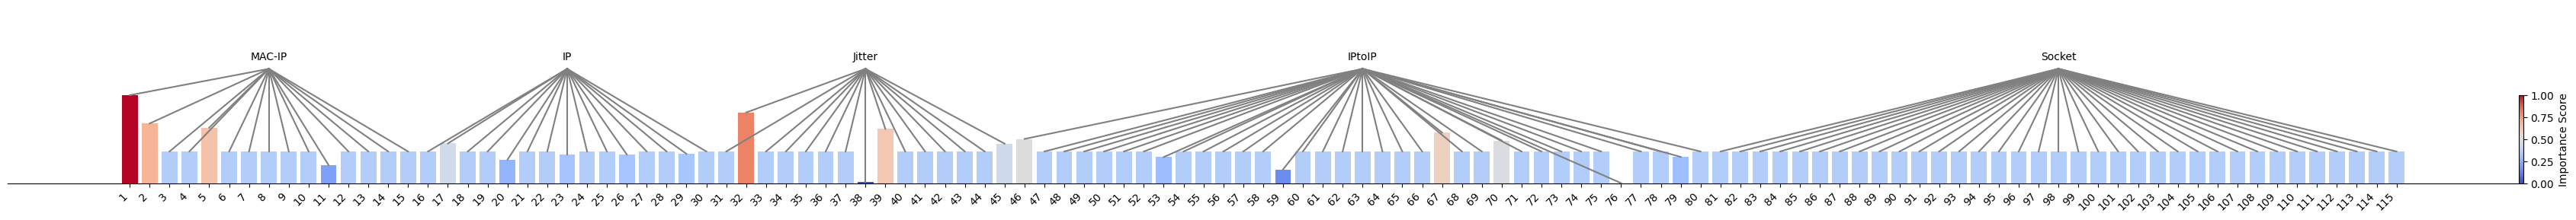

In [ ]:
kitsune_tp_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/xNIDS/Data/kitsune_selected_tp_rows.csv")
kitsune_tp_current_sample = kitsune_tp_data.iloc[-1]
kitsune_tp_history_samples = kitsune_tp_data.iloc[:-1]
kitsune_tp_prediction_score = 0.26677650458466096
kitsune_tp_explanation = Explanation(kitsune_tp_current_sample.values.reshape(1,-1), kitsune_tp_history_samples, kitsune_model, kitsune_tp_prediction_score, kitsune_feature_names, kitsune_group_sizes, 'kitsune')
kitsune_tp_explanation.capture_relevant_history()
kitsune_tp_explanation.weighted_sampling(num_samples)
kitsune_tp_explanation.sparse_group_lasso()
kitsune_tp_explanation.visualization(kitsune_group_sizes, kitsune_group_names, kitsune_feature_names)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 115)]             0         
                                                                 
 dense (Dense)               (None, 256)               29696     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

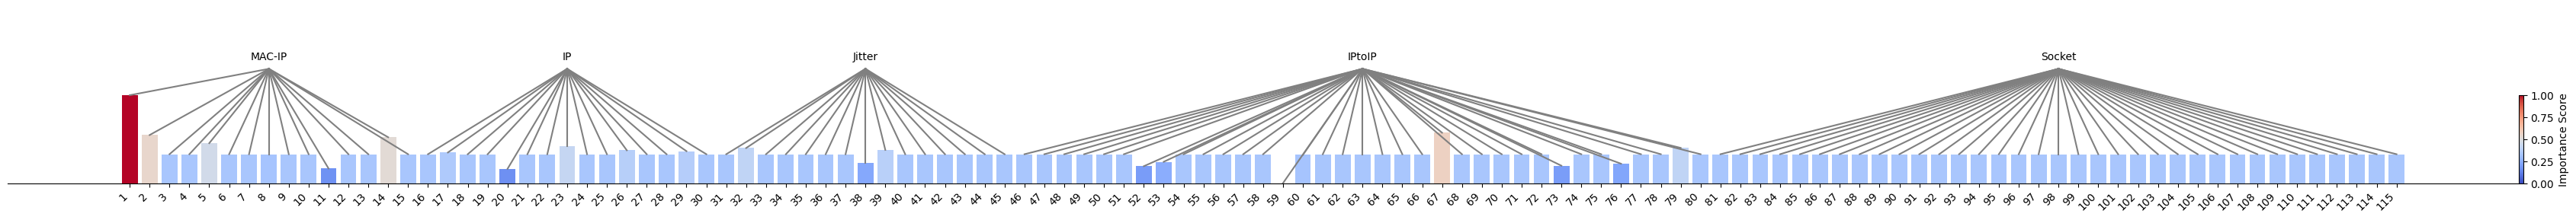

In [ ]:
kitsune_fn_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/xNIDS/Data/kitsune_selected_fn_rows.csv")
kitsune_fn_current_sample = kitsune_fn_data.iloc[-1]
kitsune_fn_history_samples = kitsune_fn_data
kitsune_fn_prediction_score = 0.14151900999030606
kitsune_fn_explanation = Explanation(kitsune_fn_current_sample.values.reshape(1,-1), kitsune_fn_history_samples, kitsune_model, kitsune_fn_prediction_score, kitsune_feature_names, kitsune_group_sizes, 'kitsune')
kitsune_fn_explanation.capture_relevant_history()
kitsune_fn_explanation.weighted_sampling(num_samples)
kitsune_fn_explanation.sparse_group_lasso()
kitsune_fn_explanation.visualization(kitsune_group_sizes, kitsune_group_names, kitsune_feature_names)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 115)]             0         
                                                                 
 dense (Dense)               (None, 256)               29696     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0     

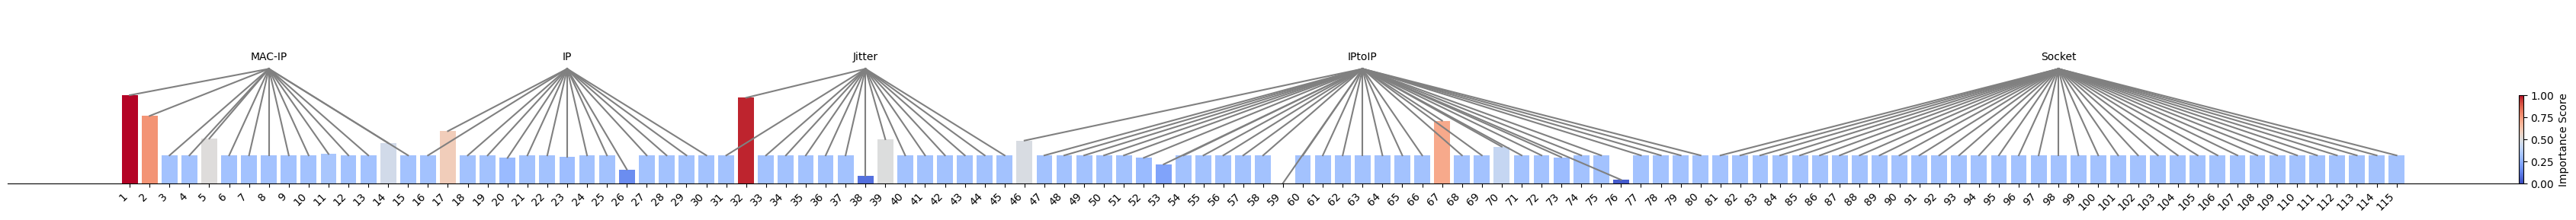

In [ ]:
kitsune_fp_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/xNIDS/Data/kitsune_selected_fp_rows.csv")
kitsune_fp_current_sample = kitsune_fp_data.iloc[-1]
kitsune_fp_history_samples = kitsune_fp_data
kitsune_fp_prediction_score = 0.3029833795420598
kitsune_fp_explanation = Explanation(kitsune_fp_current_sample.values.reshape(1,-1), kitsune_fp_history_samples, kitsune_model, kitsune_fp_prediction_score, kitsune_feature_names, kitsune_group_sizes, 'kitsune')
kitsune_fp_explanation.capture_relevant_history()
kitsune_fp_explanation.weighted_sampling(num_samples)
kitsune_fp_explanation.sparse_group_lasso()
kitsune_fp_explanation.visualization(kitsune_group_sizes, kitsune_group_names, kitsune_feature_names)

In [ ]:
# explain RNN-IDS (stateless)
# We use the false postives, and false negatives  from RNN-IDS to demostrate the explanation

# Location of the instances:

# 571  false postive  tcp http SF
# predicted_probabilities[571]  array([0.7116914], dtype=float32)

# 21930 false negatives warezmaster
# predicted_probabilities[21930] array([0.44356757], dtype=float32)


import pandas as pd
kdd_model = "/content/drive/MyDrive/Colab Notebooks/xNIDS/Models/lstm_model.h5"
kdd_feature_names = np.load('/content/drive/MyDrive/Colab Notebooks/xNIDS/Data/kdd_after_features.npy')
kdd_feature_names =kdd_feature_names[kdd_feature_names != 'Class']
kdd_group_sizes = [1, 2, 1, 1, 1, 1, 2, 1, 3, 3,1,2,1,1,4,2,2,5,4,3,70,11 ]
kdd_group_names = [f'g{i}' for i in range(1,len(kdd_group_sizes)+1)]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                34600     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 34,651
Trainable params: 34,651
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 1s/step
original score: 0.44356757
difference: [[5.9604645e-08]]
The output is determined by current input.
weight: 0.5
4/4 [==============================] - 2s 6ms/step


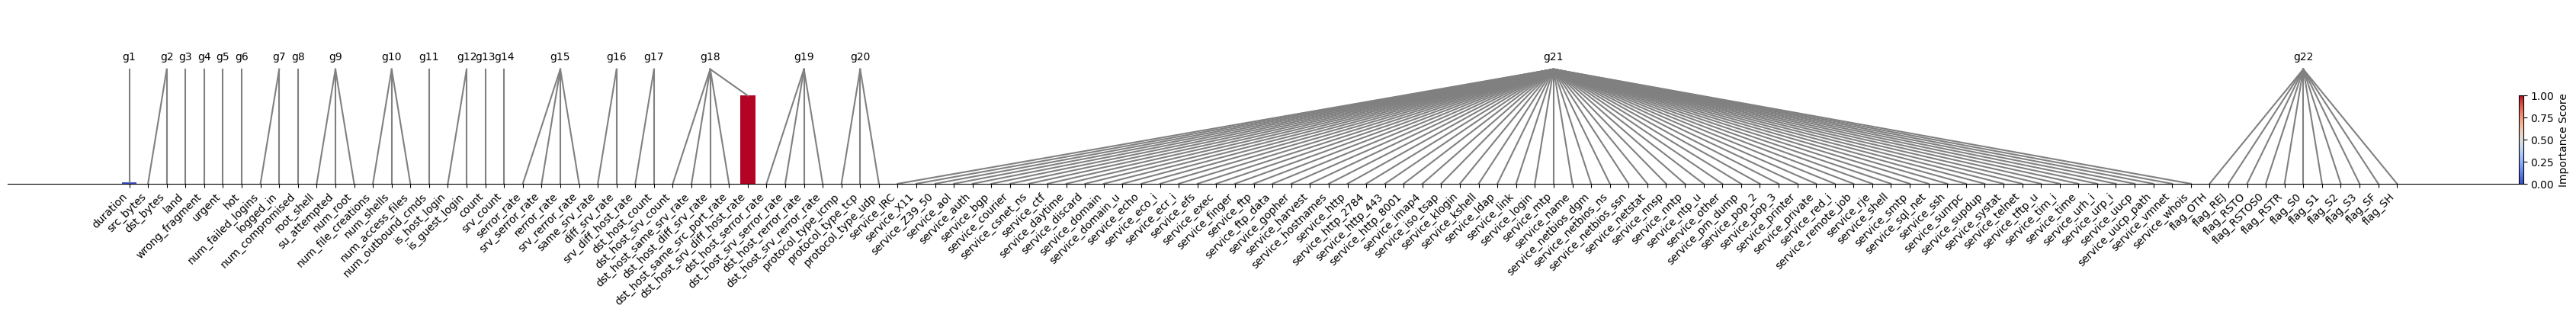

In [ ]:
kdd_fn_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/xNIDS/Data/kdd_selected_fn_rows_122.csv")
kdd_fn_feature_data = kdd_fn_data.iloc[:,1 :]
kdd_fn_current_sample = kdd_fn_feature_data.iloc[-1]
kdd_fn_current_sample = kdd_fn_current_sample.values.reshape(1,1,-1)
kdd_fn_history_samples = kdd_fn_feature_data
kdd_fn_history_samples = kdd_fn_history_samples.values.reshape(len(kdd_fn_history_samples),1,-1)
kdd_fn_prediction_score = 0.44356757
kdd_fn_explanation = Explanation(kdd_fn_current_sample, kdd_fn_history_samples, kdd_model, kdd_fn_prediction_score, kdd_feature_names, kdd_group_sizes,'lstm')
kdd_fn_explanation.capture_relevant_history()
kdd_fn_explanation.weighted_sampling(num_samples)
kdd_fn_explanation.sparse_group_lasso()
kdd_fn_explanation.visualization(kdd_group_sizes, kdd_group_names, kdd_feature_names)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                34600     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 34,651
Trainable params: 34,651
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 524ms/step
original score: 0.7116914
difference: [[5.9604645e-08]]
The output is determined by current input.
weight: 0.5
4/4 [==============================] - 0s 4ms/step


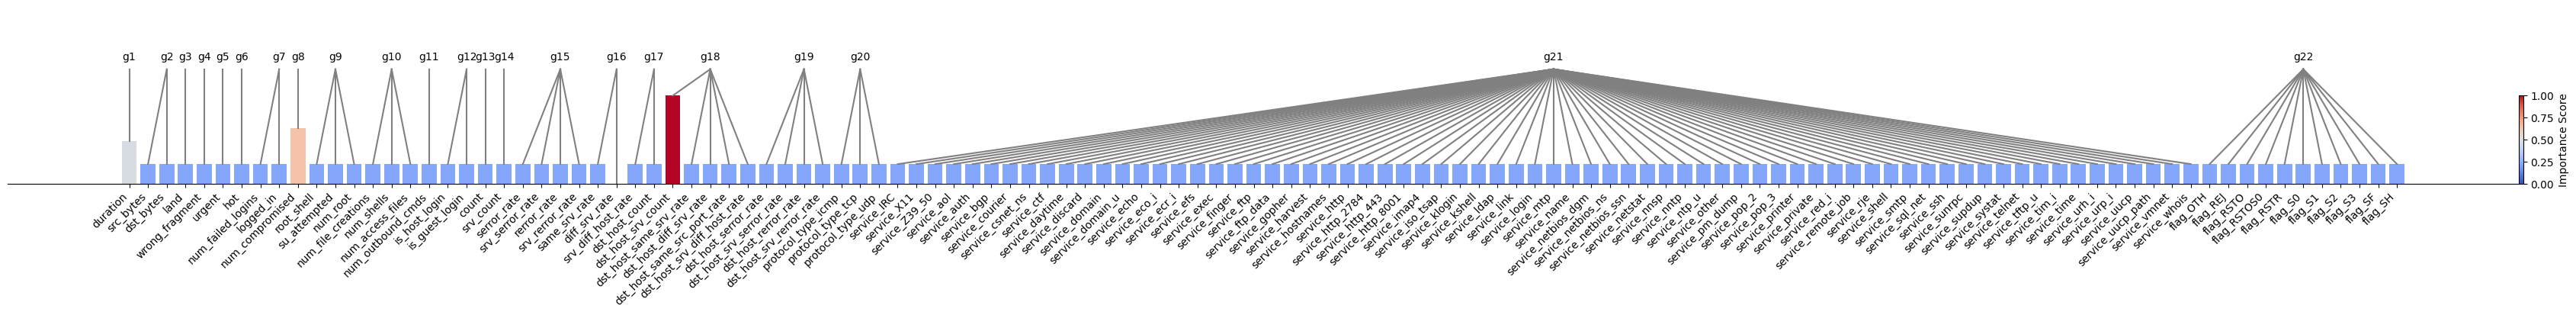

In [ ]:
kdd_fp_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/xNIDS/Data/kdd_selected_fp_rows_122.csv")
kdd_fp_feature_data = kdd_fp_data.iloc[:,1 :]
kdd_fp_current_sample = kdd_fp_feature_data.iloc[-1]
kdd_fp_current_sample = kdd_fp_current_sample.values.reshape(1,1,-1)
kdd_fp_history_samples = kdd_fp_feature_data
kdd_fp_history_samples = kdd_fp_history_samples.values.reshape(len(kdd_fp_history_samples),1,-1)
kdd_fp_prediction_score = 0.7116914
kdd_fp_explanation = Explanation(kdd_fp_current_sample, kdd_fp_history_samples, kdd_model, kdd_fp_prediction_score, kdd_feature_names, kdd_group_sizes,'lstm')
kdd_fp_explanation.capture_relevant_history()
kdd_fp_explanation.weighted_sampling(num_samples)
kdd_fp_explanation.sparse_group_lasso()
kdd_fp_explanation.visualization(kdd_group_sizes, kdd_group_names, kdd_feature_names)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (1, 1, 50)                34600     
                                                                 
 dropout (Dropout)           (1, 1, 50)                0         
                                                                 
 lstm_1 (LSTM)               (1, 10)                   2440      
                                                                 
 dropout_1 (Dropout)         (1, 10)                   0         
                                                                 
 dense (Dense)               (1, 1)                    11        
                                                                 
Total params: 37,051
Trainable params: 37,051
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 1s 933ms/step

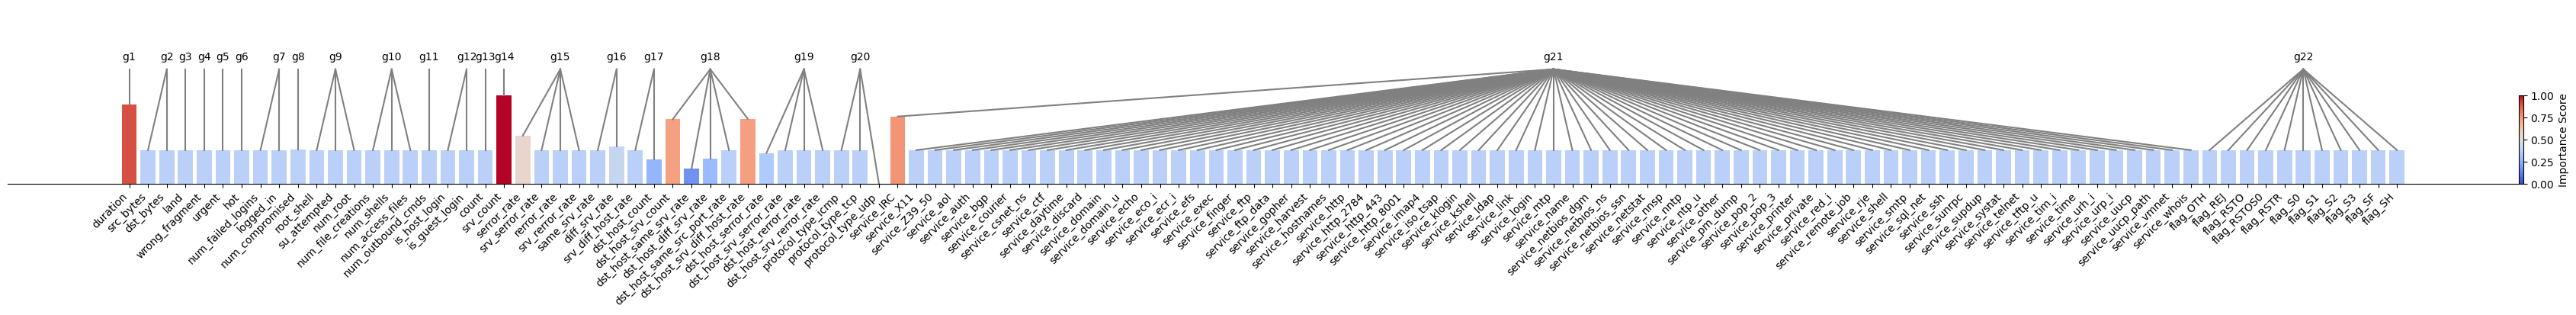

In [ ]:
# explain stateful lstm
# 19114 fale positive
# predicted_probabilities[19114] array([0.92638266], dtype=float32)
# 19114	0	udp	private	SF	54	51	0

kdd_history_model = "/content/drive/MyDrive/Colab Notebooks/xNIDS/Models/lstm_history_model.h5"

kdd_history_fp_data  = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/xNIDS/Data/kdd_history_selected_fp_rows_122.csv")
kdd_history_fp_feature_data = kdd_history_fp_data.iloc[:,1 :]
kdd_history_fp_current_sample = kdd_history_fp_feature_data.iloc[-1]
kdd_history_fp_current_sample = kdd_history_fp_current_sample.values.reshape(1,1,-1)
kdd_history_fp_history_samples = kdd_history_fp_feature_data
kdd_history_fp_history_samples = kdd_history_fp_history_samples.values.reshape(len(kdd_history_fp_history_samples),1,-1)
kdd_history_fp_prediction_score = 0.92638266
kdd_history_fp_explanation = Explanation(kdd_history_fp_current_sample, kdd_history_fp_history_samples, kdd_history_model, kdd_history_fp_prediction_score, kdd_feature_names, kdd_group_sizes,'lstmHistory')
kdd_history_fp_explanation.capture_relevant_history()
kdd_history_fp_explanation.weighted_sampling(num_samples)
kdd_history_fp_explanation.sparse_group_lasso()
kdd_history_fp_explanation.visualization(kdd_group_sizes, kdd_group_names, kdd_feature_names)